In [36]:
import random
import wandb
import torch
from transformers.utils import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
from transformers import AutoModel, AutoModelForSequenceClassification

In [37]:
import data_processing
from data_processing import ModelReadyDataset
data = data_processing.load_data("Full_HDL_dataset_unnormalized_no_nan.pickle")

In [38]:
a = data[1]["data"][:, 1]

In [39]:
b = data[300]["data"][:,1]

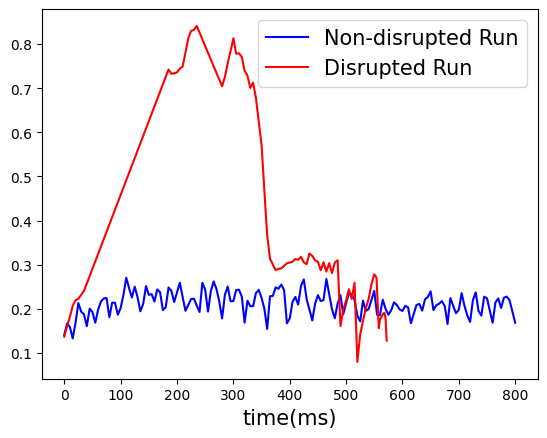

In [46]:
import matplotlib.pyplot as plt

plt.plot(a, color = "blue", label="Non-disrupted Run")
plt.plot(b, color = "red", label="Disrupted Run")
plt.xlabel("time(ms)", fontsize=15)
plt.legend(fontsize=15)


In [4]:
train, test = train_test_split(
    data, 
    end_cutoff=.8, 
    machine_hyperparameters={"cmod":1.0, "d3d":1.0, "east":1.0},
    train_size=.97)

In [7]:
run = wandb.init(project="HDL-improvement-transformer", job_type="extract-model", entity="lucas-spangher")
artifact= run.use_artifact("model-vy7ggzg4:v0")

artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-vy7ggzg4:v0, 62.73MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.2


In [8]:
eval_model = model.eval()
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 13)
    (wpe): Embedding(2048, 13)
    (drop): Dropout(p=1e-05, inplace=False)
    (h): ModuleList(
      (0-14): 15 x GPT2Block(
        (ln_1): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.13801574268527766, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=13, out_features=2, bias=False)
)

## Visualization

In [54]:
def visualize_attention_weights(inputs, model, layer=0, head=0):

    # Get the attention weights from the model
    with torch.no_grad():
        outputs = model(inputs_embeds=inputs["inputs_embeds"], output_attentions=True)
        attentions = outputs.attentions

    # Extract the attention weights of the specified layer and head
    attention = attentions[layer][0, head].detach().numpy()

    # Normalize the attention weights
    attention = attention / np.sum(attention, axis=-1, keepdims=True)

    # Decode the input tokens to obtain the input text
    x_labels = list(range(len(inputs["inputs_embeds"])))

    # Visualize the attention weights using a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(attention, cmap="viridis", vmax=.3)
    plt.xlabel("Key (Input)")
    plt.ylabel("Query (Output)")
    plt.title(f"Attention Weights (Layer {layer + 1}, Head {head + 1})")
    plt.show()


In [33]:
test_shot = test[1]
test_shot.keys()
test_shot["inputs_embeds"] = torch.tensor(test_shot["inputs_embeds"], dtype=torch.float16)

/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_36690/2300701479.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_shot["inputs_embeds"] = torch.tensor(test_shot["inputs_embeds"], dtype=torch.float16)


GPT2ForSequenceClassification will not detect padding tokens in `inputs_embeds`. Results may be unexpected if using padding tokens in conjunction with `inputs_embeds.`


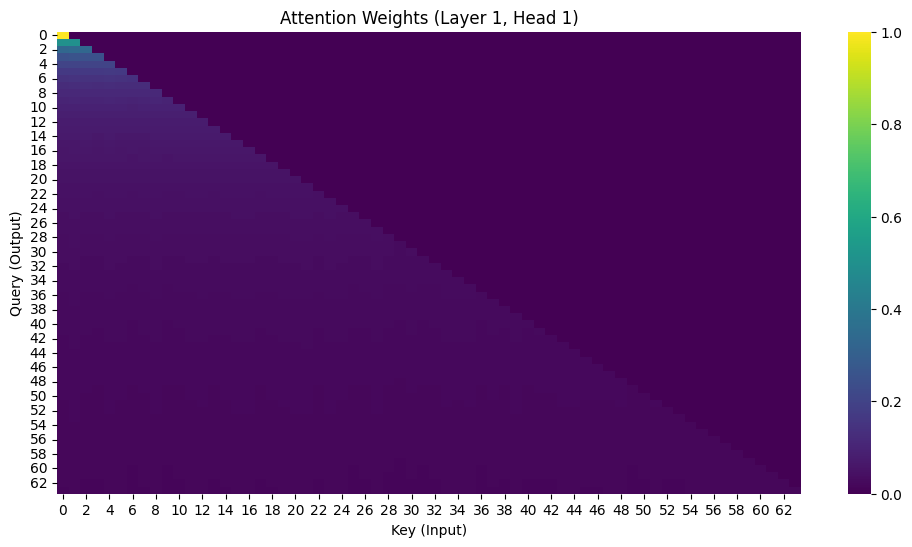

In [34]:
visualize_attention_weights(test_shot, eval_model, layer=0, head=0)

GPT2ForSequenceClassification will not detect padding tokens in `inputs_embeds`. Results may be unexpected if using padding tokens in conjunction with `inputs_embeds.`


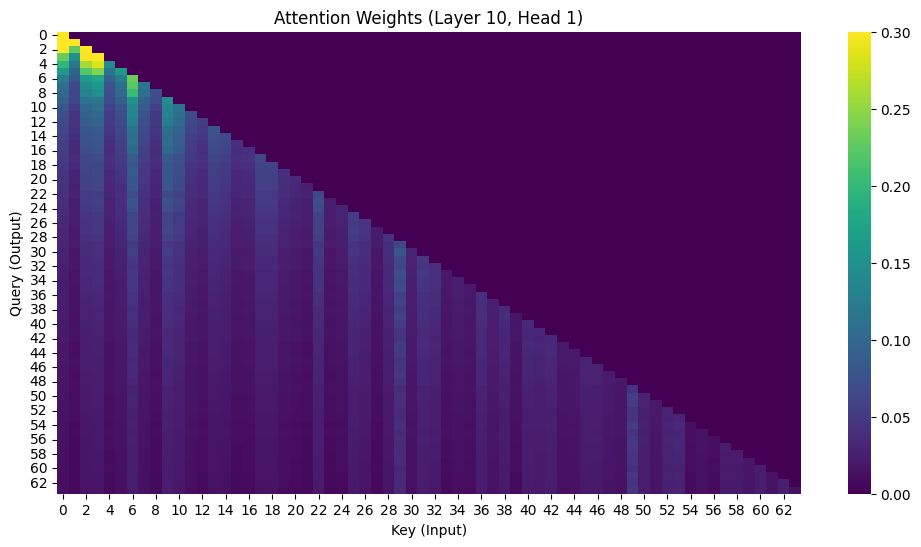

In [55]:
visualize_attention_weights(test_shot, eval_model, layer=9)

In [53]:
test_shot["inputs_embeds"].shape

torch.Size([64, 13])

## plot IP

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


<Axes: >

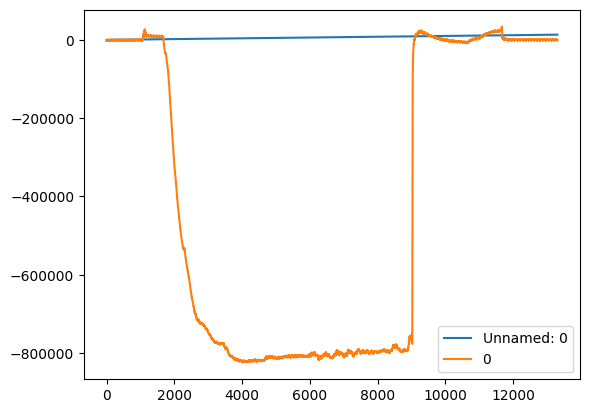

In [6]:
ip = pd.read_csv("../../data_retrieval/ip_test.csv")
ip.plot()

In [9]:
ip.iloc[:, 1]

0       -1872.70530
1       -1870.65600
2       -1872.70530
3       -2187.89670
4       -1557.51380
            ...    
13307    -579.15045
13308    -579.15045
13309   -1205.43490
13310   -1203.38560
13311    -892.29266
Name: 0, Length: 13312, dtype: float64